# This notebook is a walkthrough for running Metadynamics simulations using a deep time-lagged variational autoencoder (VDE). 

In [37]:
import sys,os
from glob import glob
import numpy as np
import pandas as pd
import msmbuilder.utils as msmutils
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch import optim
from msmbuilder.utils import load
import msmexplorer as msme
%pylab inline
import seaborn as sns
sns.set_palette('colorblind')
sns.set_style('whitegrid')
sns.set_context("poster",1.3)
from msmbuilder.cluster import MiniBatchKMeans
from msmbuilder.msm import MarkovStateModel
import msmexplorer as msme
import mdtraj as md
from vde_metadynamics import *
%load_ext autoreload
%autoreload 2
import pandas as pd
from msmbuilder.featurizer import ContactFeaturizer,DihedralFeaturizer
from msmbuilder.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/Users/muneeb/anaconda/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['load']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [4]:
#lets load up the training data and visualization data

In [5]:
raw_feat = load("./mdl_dir/raw_features.pkl")
tica_data = load("./mdl_dir/tica_features.pkl")

In [6]:
sin_cos_feat = load("./mdl_dir/features.pkl")
df = pd.read_pickle("./mdl_dir/feature_descriptor.pkl")

In [8]:
# There are 4 inputs to our network, each of which is described below

In [9]:
df

,atominds,featuregroup,featurizer,otherinfo,resids,resnames,resseqs
0,"[4, 6, 8, 14]",phi,Dihedral,sin,"[0, 1]","[ACE, ALA]","[1, 2]"
1,"[4, 6, 8, 14]",phi,Dihedral,cos,"[0, 1]","[ACE, ALA]","[1, 2]"
2,"[6, 8, 14, 16]",psi,Dihedral,sin,"[1, 2]","[ALA, NME]","[2, 3]"
3,"[6, 8, 14, 16]",psi,Dihedral,cos,"[1, 2]","[ALA, NME]","[2, 3]"


In [11]:
# we have 17269 (172.69ns) training examples

In [12]:
sin_cos_feat[0].shape

(17269, 4)

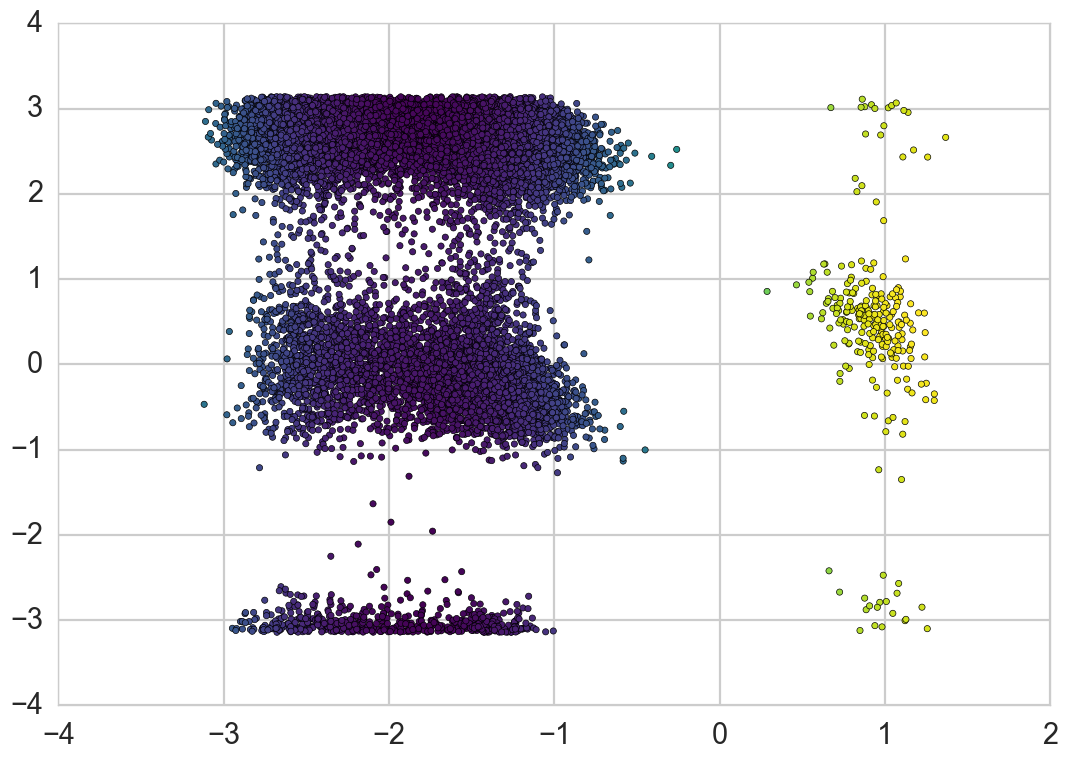

In [104]:
# lets visualize the data, and the dominant tICA solution
scatter(raw_feat[0][:,0],raw_feat[0][:,1],c=tica_data[0],cmap='viridis')

# We can fit a Variational dynamics encoder(VDE) to this data. 
# The VDE is designed to learn slow dynamics within trajectory datasets
# The VDE code is available from the MSMBUILDER GITHUB
# https://github.com/msmbuilder/vde

In [20]:
from vde import VDE

# You can train a new model

In [39]:
#model = VDE(4,100,hidden_layer_depth=2,hidden_size=16,n_epochs=50,learning_rate=1e-3)
# model.fit(sin_cos_feat)
# torch.save(model,"trained_ala.pkl")

# Or use one that we have already trained 

In [24]:
model = torch.load("./mdl_dir/trained_ala.pkl")
model.eval()
model.dtype = torch.DoubleTensor
model.use_cuda =False
model.cpu()
model.double()

/Users/muneeb/anaconda/lib/python3.5/site-packages/torch/serialization.py:286: SourceChangeWarning: source code of class 'vde.vde.VDE' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/muneeb/anaconda/lib/python3.5/site-packages/torch/serialization.py:286: SourceChangeWarning: source code of class 'vde.vde.Encoder' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/muneeb/anaconda/lib/python3.5/site-packages/torch/serialization.py:286: SourceChangeWarning: source code of class 'vde.vde.Lambda' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump

VDE (
  (encoder): Encoder (
    (input_layer): Sequential (
      (0): Linear (4 -> 16)
      (1): Swish (
        (sigmoid): Sigmoid ()
      )
    )
    (hidden_network): Sequential (
      (0): Sequential (
        (0): Linear (16 -> 16)
        (1): Swish (
          (sigmoid): Sigmoid ()
        )
      )
      (1): Sequential (
        (0): Linear (16 -> 16)
        (1): Swish (
          (sigmoid): Sigmoid ()
        )
      )
    )
    (output_layer): Sequential (
      (0): Linear (16 -> 1)
    )
    (lmbd): Lambda (
      (z_mean): Linear (1 -> 1)
      (z_log_var): Linear (1 -> 1)
    )
  )
  (decoder): Decoder (
    (input_layer): Sequential (
      (0): Linear (1 -> 1)
      (1): Swish (
        (sigmoid): Sigmoid ()
      )
    )
    (hidden_network): Sequential (
      (0): Sequential (
        (0): Linear (1 -> 16)
        (1): Swish (
          (sigmoid): Sigmoid ()
        )
      )
      (1): Sequential (
        (0): Linear (16 -> 16)
        (1): Swish (
         

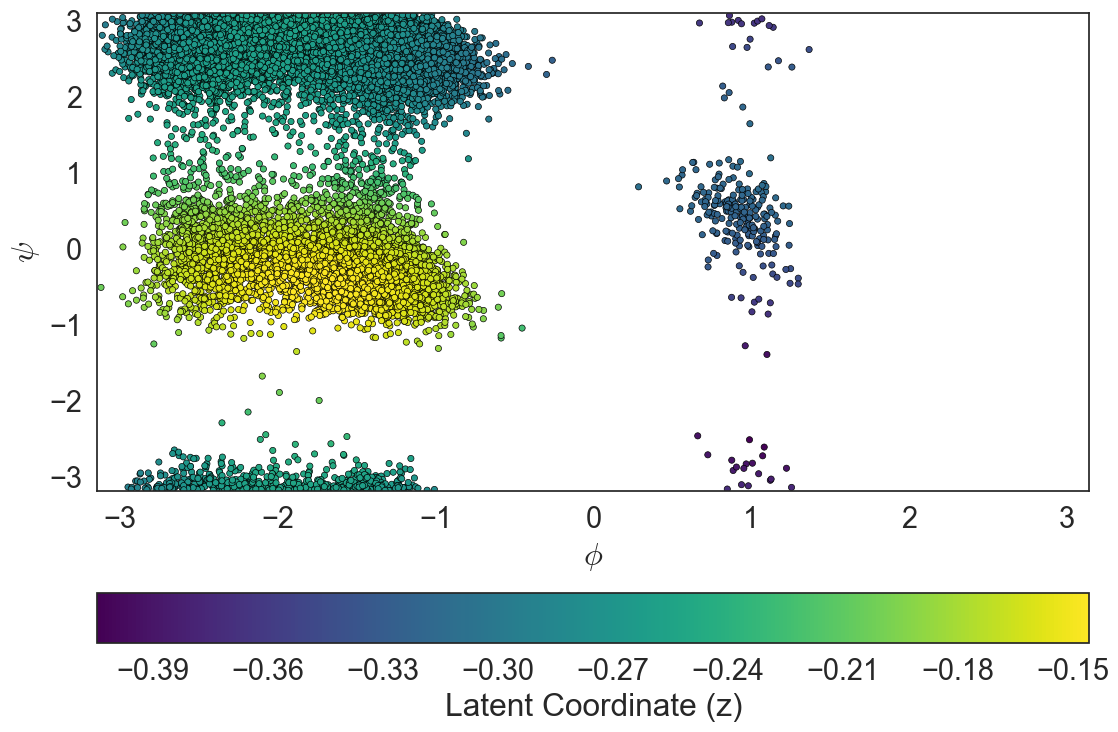

In [27]:
model.eval()
X=Variable(torch.from_numpy(sin_cos_feat[0]).type(model.dtype))

output = model.encoder.output_layer(model.encoder.hidden_network(model.encoder.input_layer(X))).cpu().data.numpy()
p=scatter(raw_feat[0][:,0],raw_feat[0][:,1],c=output,cmap='viridis')
xlim([-pi,pi])
ylim([-pi,pi])
xlabel(r'$\phi$',)
ylabel(r'$\psi$')
cb=colorbar(p,orientation="horizontal")
cb.set_label("Latent Coordinate (z)")

 ## As the graph coloring shows , our VDE coordinate highly non-linear that goes through all major Alanine states using a single collective variable
    

In [28]:
# We can compare it to our regular tICA solution

In [32]:
ala_tica_mdl =load("./mdl_dir/tica_mdl.pkl")
ala_tica_mdl.commute_mapping=False

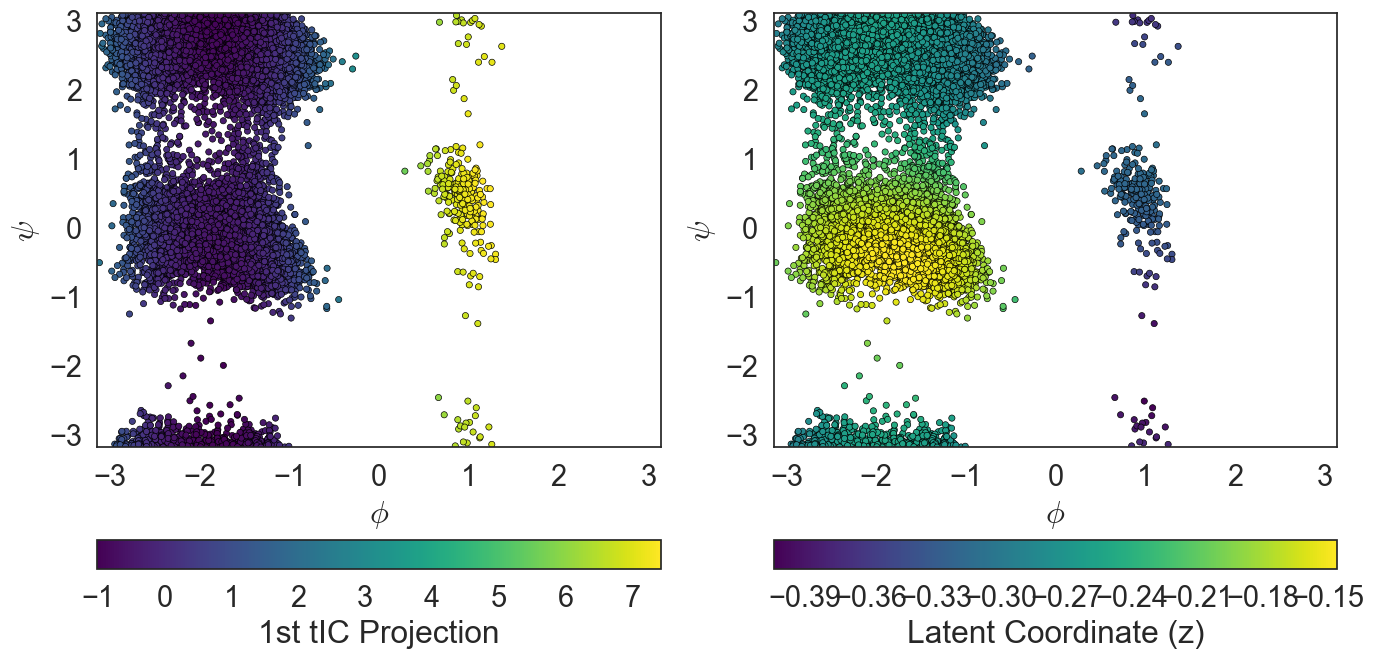

In [33]:
figure(figsize=(16,8))
subplot(1,2,1)
tf = ala_tica_mdl.transform(sin_cos_feat)[0][:,0]
p=scatter(raw_feat[0][:,0],raw_feat[0][:,1],c=(tf),cmap='viridis')
xlabel(r'$\phi$')
ylabel(r'$\psi$')
xlim([-pi,pi])
ylim([-pi,pi])
cb=colorbar(p,orientation="horizontal")
cb.set_label("1st tIC Projection")



subplot(1,2,2)
p=scatter(raw_feat[0][:,0],raw_feat[0][:,1],c=output,cmap='viridis')
xlim([-pi,pi])
ylim([-pi,pi])
xlabel(r'$\phi$',)
ylabel(r'$\psi$')
cb=colorbar(p,orientation="horizontal")
cb.set_label("Latent Coordinate (z)")


# The non-linear solutions better separate the y-axis than the linear tica solutions

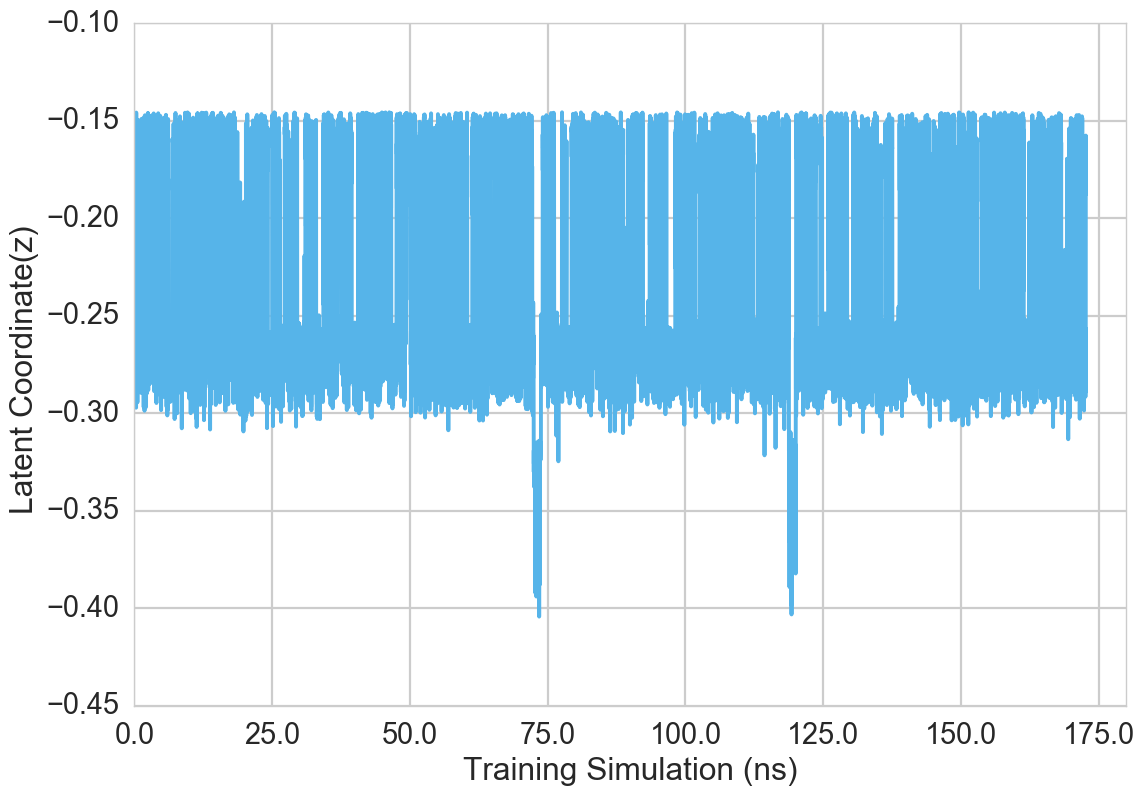

In [40]:
plot(output[:,0],c=sns.color_palette("colorblind")[5])
xticks([0,2500,5000,7500,10000,12500,15000,17500],np.array([0,2500,5000,7500,10000,12500,15000,17500])/100)
ylabel("Latent Coordinate(z) ")
xlabel("Training Simulation (ns)")

# Now the fun part of accerlerating this Z-coordinate using Metadynamics 
https://en.wikipedia.org/wiki/Metadynamics

## We have already written some code that will convert the VDE object into Plumed .

In [41]:
from vde_metadynamics.render_df import *
from vde_metadynamics.render_network import *

In [47]:
all_out=[]
# Add the restart
all_out.append("RESTART\n")
# Convert the raw dihedrals into something plumed can understand
all_out.extend(render_df(df))
# Convert the VDE model into something Plumed can understand
all_out.extend(render_network(model))

2
Linear (16 -> 16) 3
3
Swish (
  (sigmoid): Sigmoid ()
) 4
4
Linear (16 -> 16) 5
5
Swish (
  (sigmoid): Sigmoid ()
) 6


# Here is the full network (Note its missing the metadynamics section, you have to do that yourselves)

In [48]:
print("".join(all_out))

RESTART
TORSION ATOMS=5,7,9,15 LABEL=phi_0_1 

TORSION ATOMS=7,9,15,17 LABEL=psi_1_2 

MATHEVAL ARG=phi_0_1 FUNC=sin(x) LABEL=f0_0 PERIODIC=NO 

MATHEVAL ARG=phi_0_1 FUNC=cos(x) LABEL=f0_1 PERIODIC=NO 

MATHEVAL ARG=psi_1_2 FUNC=sin(x) LABEL=f0_2 PERIODIC=NO 

MATHEVAL ARG=psi_1_2 FUNC=cos(x) LABEL=f0_3 PERIODIC=NO 

COMBINE LABEL=l1_0nb ARG=l0_0,l0_1,l0_2,l0_3 COEFFICIENTS=0.07340843975543976,0.5181626081466675,-0.31691858172416687,-0.031756311655044556 PERIODIC=NO 
MATHEVAL ARG=l1_0nb FUNC=x+0.31510797142982483 LABEL=l1_0 PERIODIC=NO 
COMBINE LABEL=l1_1nb ARG=l0_0,l0_1,l0_2,l0_3 COEFFICIENTS=0.07954739779233932,-0.5078519582748413,0.3322467803955078,-0.2851238548755646 PERIODIC=NO 
MATHEVAL ARG=l1_1nb FUNC=x+0.2647515833377838 LABEL=l1_1 PERIODIC=NO 
COMBINE LABEL=l1_2nb ARG=l0_0,l0_1,l0_2,l0_3 COEFFICIENTS=0.19853073358535767,-0.24209196865558624,0.12398649752140045,-0.47892245650291443 PERIODIC=NO 
MATHEVAL ARG=l1_2nb FUNC=x+-0.314288467168808 LABEL=l1_2 PERIODIC=NO 
COMBINE LABEL=

In [35]:
# The network can be written to disk for sampling across mutant FFs.

# with open("./plumed.dat","w") as f:
#     f.writelines(all_out)

In [61]:
# lets look at the results 

In [92]:
from msmbuilder.utils import load
from pyemma.thermo import mbar

In [93]:
feat = load("./mdl_dir/featurizer.pkl")
tica_mdl = load("./mdl_dir/tica_mdl.pkl")
new_km=load("./mdl_dir/kmeans_mdl.pkl")
msm_mdl = load("./mdl_dir/msm_mdl.pkl")

In [94]:
tica_mdl.commute_mapping = False

In [95]:
def get_mbar_obj(base_loc="./amber99_test/results/reweight/"):
    base_loc= os.path.join(base_loc)
    #base_loc=os.path.join(prim_base_loc,"fip")
    stride=1
    offset=0
    traj = md.load("%s/../trajectory.xtc"%base_loc,top="%s/../top.pdb"%base_loc,stride=stride)
    bias = np.loadtxt("%s/BIAS"%base_loc)[::1][:,-1]
    raw_feat = DihedralFeaturizer(sincos=False).transform([traj])[0]
    raw_feats = feat.transform([traj])
    tica_feat = tica_mdl.transform(raw_feats)
    ass = new_km.transform([tica_feat[0][:,:2]])

    X=Variable(torch.from_numpy(raw_feats[0]).type(model.dtype))

    model.eval()
    model.encoder.lmbd.scale = 0
    deep_feat = model.encoder.output_layer(model.encoder.hidden_network(model.encoder.input_layer(X))).cpu().data.numpy()

    ct = 0

    ttrajs = np.repeat(0,len(ass[0]))
    dtrajs = ass[0]
    biases = [np.array([(bias-ct)/2.5]).T]
    mbar_obj = mbar(ttrajs, dtrajs, biases)
    return mbar_obj,raw_feat,tica_feat,deep_feat,ass

In [96]:
amber_mbar,amber_feat,amber_tica_feat,amber_deep,amber_ass = get_mbar_obj()

In [97]:
charmmm_mbar,charmm_feat,charmm_tica_feat,charmm_deep,charmm_ass = get_mbar_obj("./charmm_test/results/reweight/")

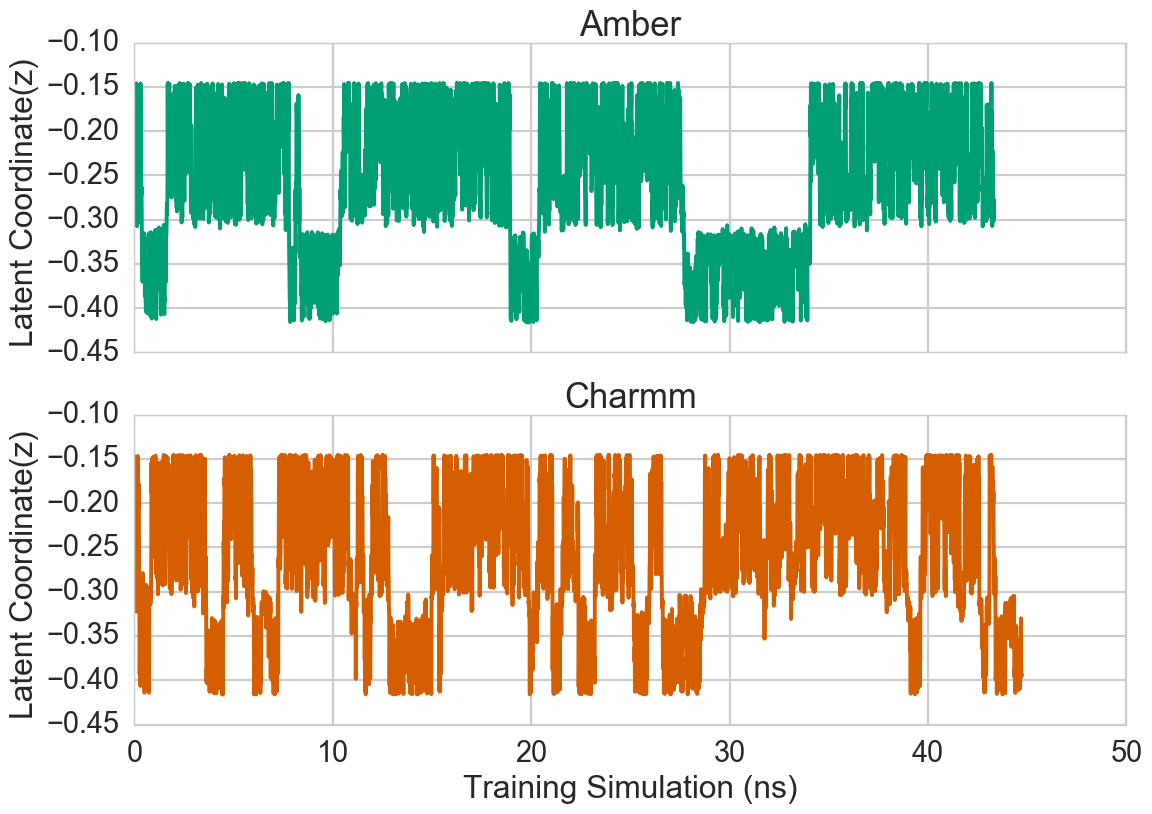

In [98]:
ax=subplot(2,1,1)
ax.plot(amber_deep,c=clr_plt[1])
ax.set_title("Amber")
xticks([0,1000,2000,3000,4000,5000],[])
ylabel("Latent Coordinate(z) ")
ax=subplot(2,1,2)
ax.plot(charmm_deep,c=clr_plt[2])
ax.set_title("Charmm")
xticks([0,1000,2000,3000,4000,5000],[0,10,20,30,40,50])
ylabel("Latent Coordinate(z) ")
xlabel("Training Simulation (ns)")

# We have many many more transitions in 1/4 the simulation time! 

/Users/muneeb/anaconda/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/Users/muneeb/anaconda/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


(-0.5, 4)

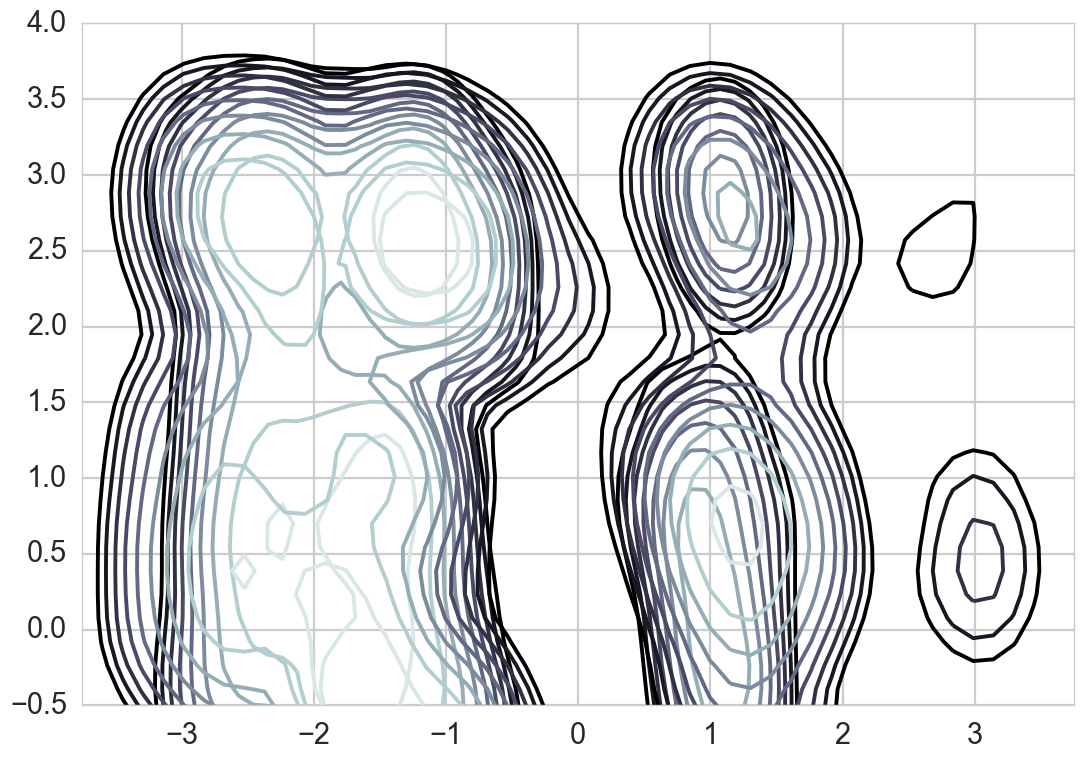

In [99]:
amber_data=charmm_data=None
x0,amber_data = msme.plot_free_energy(amber_feat,obs=[0,1],pi=[amber_mbar.pi_full_state[i] for i in amber_ass][0],
                                    cmap='jet',n_samples=50000,\
                      gridsize=50,temperature=300,shade=False,return_data=True,)
x1,charmm_data=msme.plot_free_energy(charmm_feat,obs=[0,1], pi=[charmmm_mbar.pi_full_state[i] for i in charmm_ass][0],
                                  cmap='jet',n_samples=50000,\
                      gridsize=50,temperature=300,shade=False,return_data=True,)
ylim([-.5,4])


In [100]:
import numpy as np
import matplotlib.pyplot as plt

sns.set_context("poster",1.3)

/Users/muneeb/anaconda/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/Users/muneeb/anaconda/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


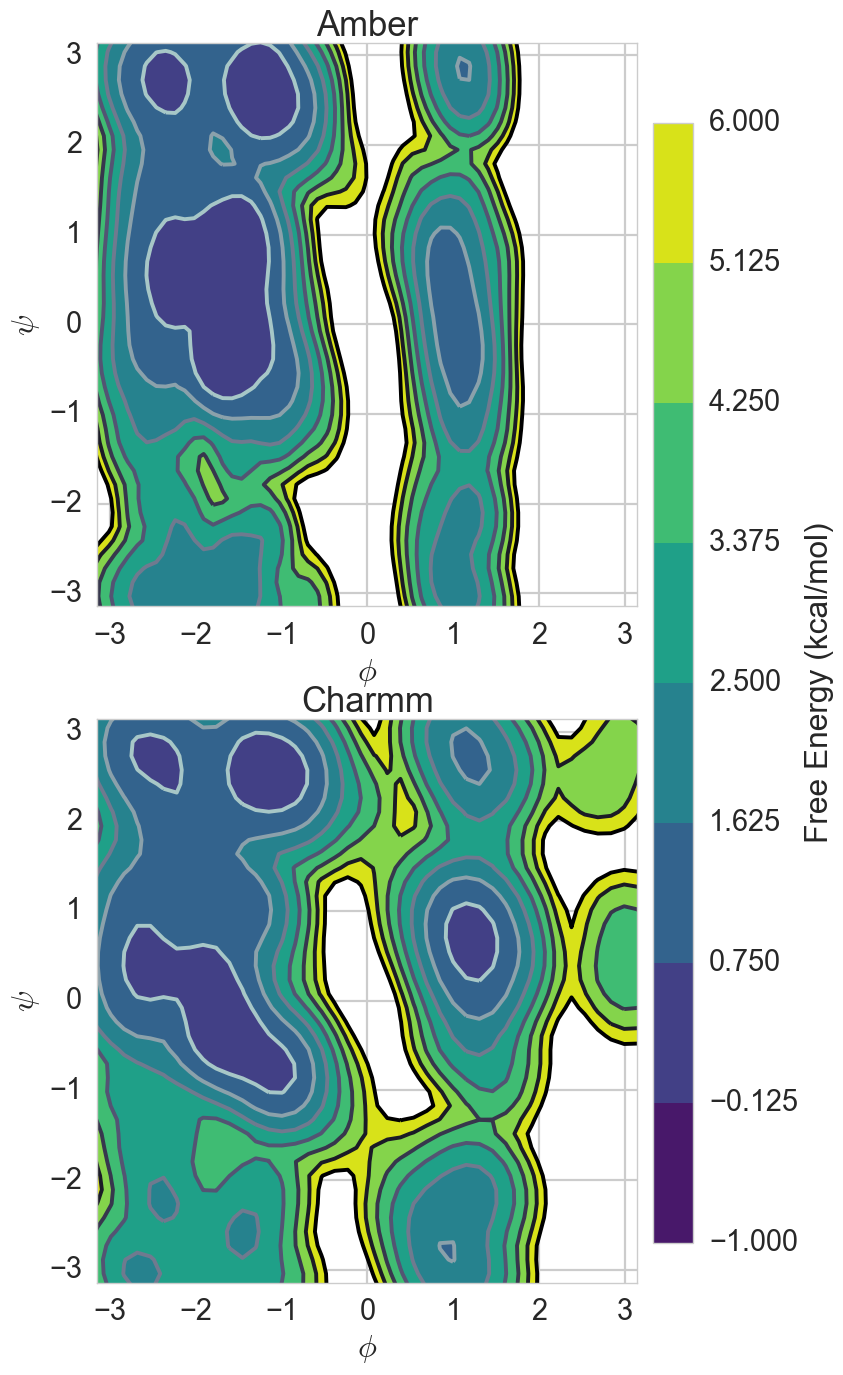

In [101]:

x,y,j1=amber_data
x2,y2,j2=charmm_data
offset=j1.min()
lvls=np.linspace(-1,6,9)

fig, axes = plt.subplots(nrows=2, ncols=1,figsize=(8,16))
for ax,l,m,j,t in zip(axes.flat,[x,x2],[y,y2],[j1,j2],["Amber","Charmm"]):
    

    im=ax.contourf(l,m,j-offset,lvls,cmap='viridis',)
    ax.contour(l,m,j-offset,lvls,cmap='bone_r')
    ax.set_xlim([-pi,pi])
    ax.set_ylim([-pi,pi])
    ax.set_title(t)
    ax.set_xlabel(r'$\phi$',)
    ax.set_ylabel(r'$\psi$')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax,label="Free Energy (kcal/mol)")
plt.show()


# How do we know that we have implemented the network correctly? 
## Lets compare values!

In [102]:
# We can compute the latent variable Z from plumed (Its written in the reweight folder) against the Pytorch values 
# which is computed by the MBAR function above

# 0th column is time, 1st column is cv value, 2nd column is bias
amber_plumed_feat = np.loadtxt("./amber99_test/results/reweight/BIAS")[:,1]

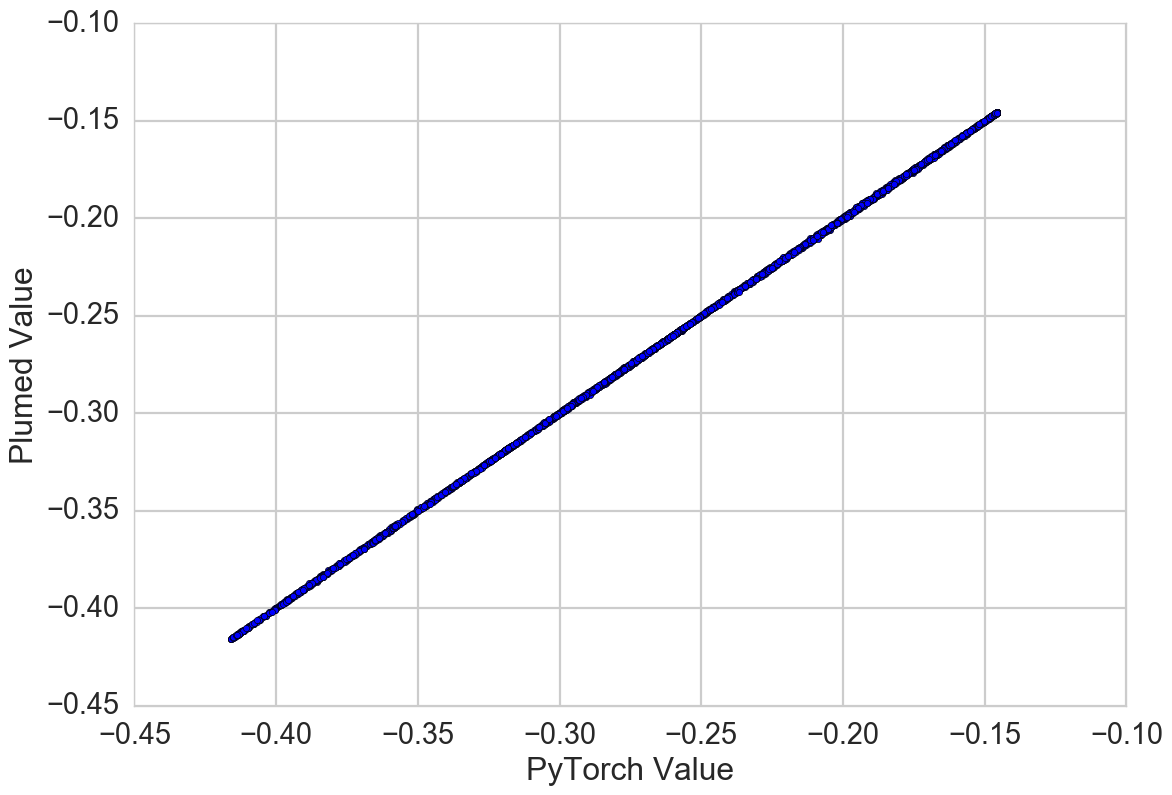

In [103]:
scatter(amber_deep, amber_plumed_feat)
xlabel("PyTorch Value")
ylabel("Plumed Value")